<a href="https://colab.research.google.com/github/nickweda/542-Semester-Project/blob/main/DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Kaggle Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Data Exploration

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load labels. 35,000 Train Labels. Left eye and right eye.
labels = pd.read_csv('/content/drive/MyDrive/drDataset/trainLabels.csv')

# Display the first few rows of the dataset
labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


**Data Exploration:**

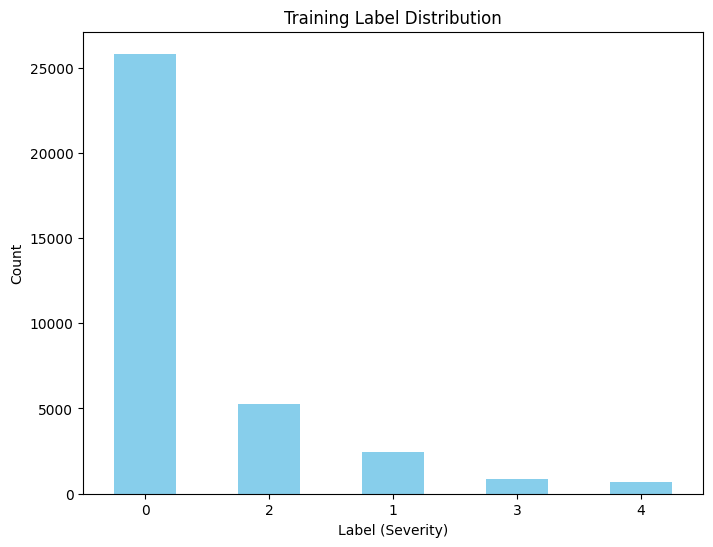

In [ ]:
# Count the occurrences of each label (assuming 'level' is the column name for labels)
label_counts = labels['level'].value_counts()

# Calculate percentages
label_percentages = (label_counts / len(labels)) * 100

# Display results
# print("Label Counts:")
# print(label_counts)
# print("\nLabel Percentages:")
# print(label_percentages)

# Optional: Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Training Label Distribution')
plt.xlabel('Label (Severity)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

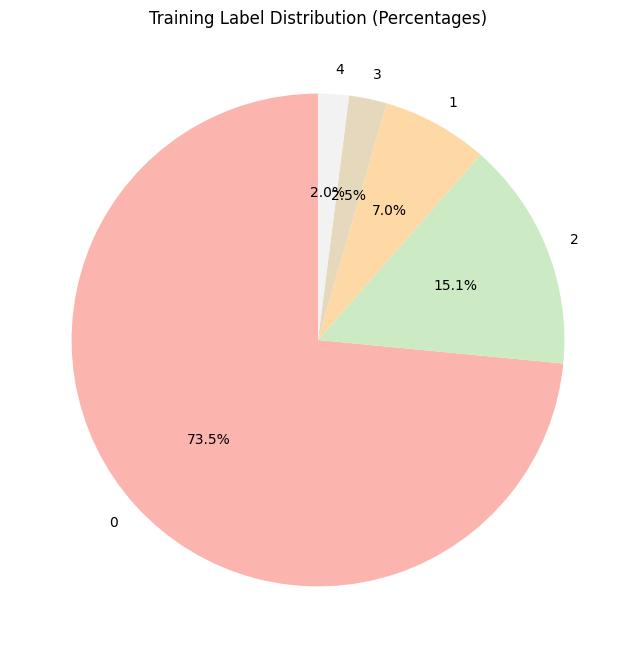

In [ ]:
# Create a pie chart
plt.figure(figsize=(8, 8))
label_percentages.plot(kind='pie',
                       autopct='%1.1f%%',
                       startangle=90,
                       colormap='Pastel1',
                       labels=label_percentages.index)  # different 'labels' argument

# Formatting the chart
plt.title('Training Label Distribution (Percentages)')
plt.ylabel('')  # Hide the ylabel
plt.show()


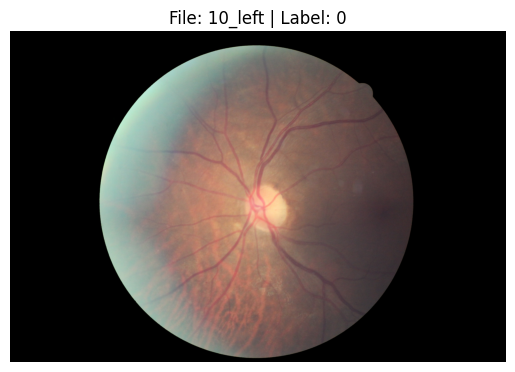

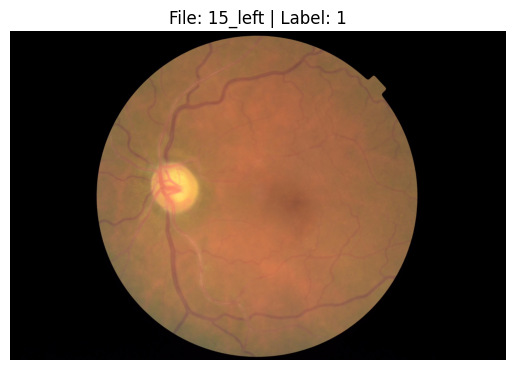

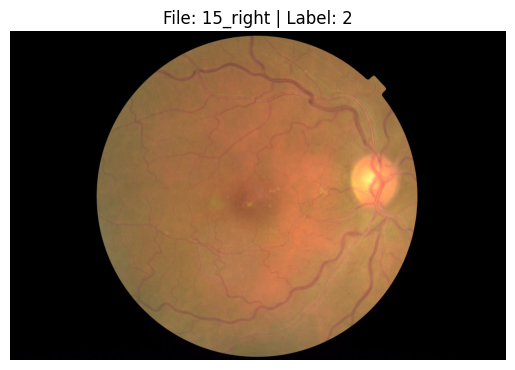

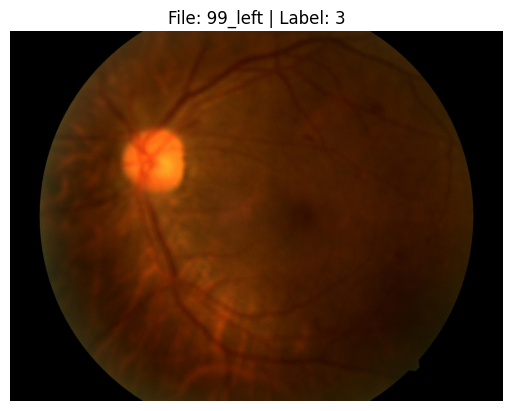

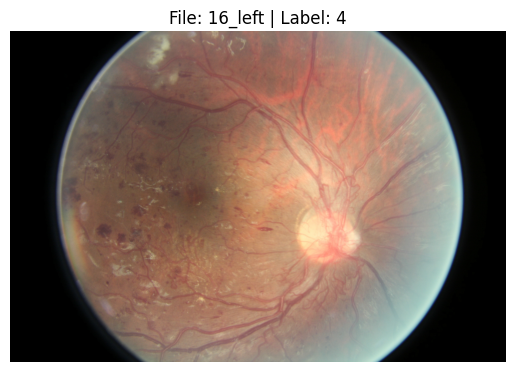

In [ ]:
# Get a sample image for each unique label
unique_labels = labels['level'].unique()
sampled_images = labels.groupby('level').first().reset_index()  # Get the first image for each label

for i in range(5): # 5 Labels in the data set. 0-4 (severity)
  image_filename = sampled_images.iloc[i]['image']
  image_path = f"/content/drive/MyDrive/drDataset/train/{image_filename}.jpeg"
  image_label = sampled_images.iloc[i]['level']

  img = Image.open(image_path)

  plt.figure()
  plt.imshow(img)
  plt.title(f"File: {image_filename} | Label: {image_label}")
  plt.axis('off')
  plt.show()

**Data Pre-Processing**

In [ ]:
# Resize the Images to 224x224 for ResNet
import os
import tensorflow as tf

In [ ]:
# Define source and target directories
source_dir = '/content/drive/MyDrive/drDataset/train'
target_dir = '/content/drive/MyDrive/drDataset/train_resized'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Resize all images while maintaining aspect ratio
for image_name in os.listdir(source_dir):

    image_path = os.path.join(source_dir, image_name)
    target_path = os.path.join(target_dir, image_name)

    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_image(image, channels=3)
    # Resize while keeping aspect ratio (Zero-Padding)
    image_resized = tf.image.resize_with_pad(image, 224, 224)
    # Convert to uint8 for saving
    image_resized = tf.cast(image_resized, tf.uint8)
    # Encode as JPEG
    encoded_image = tf.image.encode_jpeg(image_resized)
    # Write the resized image to the target directory
    tf.io.write_file(target_path, encoded_image)

KeyboardInterrupt: 

In [ ]:
# Double Check that all files were resized
FOLDER_PATH = '/content/drive/MyDrive/drDataset/train_resized'
ROOT_PATH = '/content/drive/MyDrive/'
print(len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH))))

35127


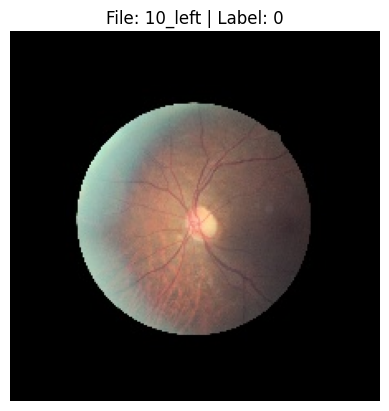

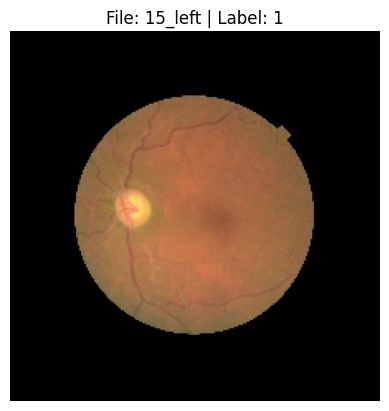

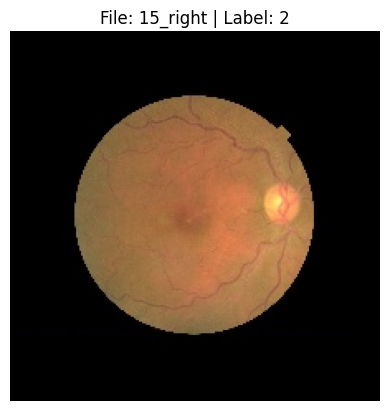

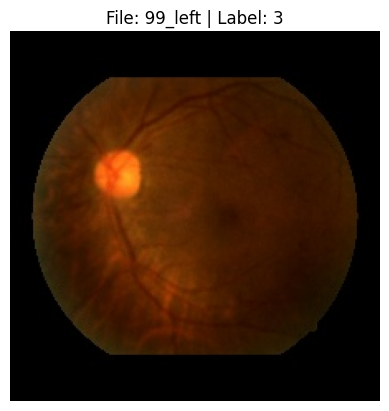

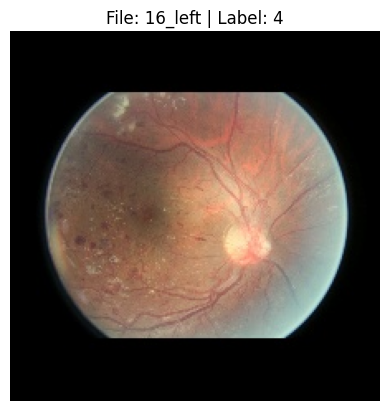

In [ ]:
# Check out those same images as before but now resized

# Get a sample image for each unique label
unique_labels = labels['level'].unique()
sampled_images = labels.groupby('level').first().reset_index()  # Get the first image for each label

for i in range(5): # 5 Labels in the data set. 0-4 (severity)
  image_filename = sampled_images.iloc[i]['image']
  image_path = f"/content/drive/MyDrive/drDataset/train_resized/{image_filename}.jpeg"
  image_label = sampled_images.iloc[i]['level']

  img = Image.open(image_path)

  plt.figure()
  plt.imshow(img)
  plt.title(f"File: {image_filename} | Label: {image_label}")
  plt.axis('off')
  plt.show()

In [13]:
import os
import tensorflow as tf
import numpy as np
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Define source and target directories
source_dir = '/content/drive/MyDrive/drDataset/train_resized'
target_dir1 = '/content/drive/MyDrive/drDataset/train_resized_224'
target_dir2 = '/content/drive/MyDrive/drDataset/train_resized_224_aug'

# Create the target directory if it doesn't exist
os.makedirs(target_dir1, exist_ok=True)
os.makedirs(target_dir2, exist_ok=True)


# Region of Interest Cropping - Zero Padding if Necessary (Don't want to introduce noise with black space)
# Note: Reflective padding does not work in this domain application!
def crop_or_pad_to_roi(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img_cropped = img[y:y+h, x:x+w]
    else:
        img_cropped = img

    h, w, c = img_cropped.shape
    if h != w:
        diff = abs(h - w)
        if h > w:
            img_padded = tf.image.resize_with_crop_or_pad(img_cropped, h, h)
        else:
            img_padded = tf.image.resize_with_crop_or_pad(img_cropped, w, w)
    else:
        img_padded = img_cropped

    if tf.is_tensor(img_padded):
        img_padded = img_padded.numpy()

    return img_padded

# Function to enhance image contrast using CLAHE - Reduces Noise
def enhance_contrast(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

# Function to resize image
def resize_image(img, target_size=224):
    return tf.image.resize(img, (target_size, target_size))

# Data augmentation using ImageDataGenerator
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)

# Process and augment specific images
def process_images(sampled_images, source_dir, target_dir1, target_dir2, target_size=224):
    for _, row in tqdm(sampled_images.iterrows(), total=len(sampled_images)):
        image_filename = row['image']
        img_path = os.path.join(source_dir, f"{image_filename}.jpeg")

        for i in range(5): # 5 images to test
          if os.path.exists(img_path):
              # Load image
              img = cv2.imread(img_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

              # Step 1: Crop or pad to ROI
              img = crop_or_pad_to_roi(img)

              # Step 2: Enhance image contrast and Noise Reduction
              img = enhance_contrast(img)

              # Step 3: Resize image
              img = resize_image(img, target_size)

              # Save resized image
              resized_save_path = os.path.join(target_dir1, f"{image_filename}.jpg")
              tf.keras.preprocessing.image.save_img(resized_save_path, img)


              # Perform Data Augmentation
              img_array = tf.keras.preprocessing.image.img_to_array(img)
              img_array = np.expand_dims(img_array, axis=0)

              augment_iter = data_gen.flow(img_array, batch_size=1)
              aug_img = augment_iter.next()[0]
              aug_img = tf.cast(aug_img, tf.uint8)
              aug_save_path = os.path.join(target_dir2, f"{image_filename}.jpg")
              tf.keras.preprocessing.image.save_img(aug_save_path, aug_img)



# Run the function for the sampled images
process_images(sampled_images, source_dir, target_dir1, target_dir2)


100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


In [14]:
# Modification: Reflective Padding


import os
import tensorflow as tf
import numpy as np
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Define source and target directories
source_dir = '/content/drive/MyDrive/drDataset/train_resized'
target_dir1 = '/content/drive/MyDrive/drDataset/train_resized_224_refl'
target_dir2 = '/content/drive/MyDrive/drDataset/train_resized_224_aug_refl'

# Create the target directory if it doesn't exist
os.makedirs(target_dir1, exist_ok=True)
os.makedirs(target_dir2, exist_ok=True)


# Region of Interest Cropping - Zero Padding if Necessary (Don't want to introduce noise with black space)
def crop_or_pad_to_roi_reflective(img, target_size=224):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img_cropped = img[y:y+h, x:x+w]
    else:
        img_cropped = img

    h, w, c = img_cropped.shape
    if h != w:
        diff = abs(h - w)
        if h > w:  # Height is greater than width
            pad_width = diff // 2
            img_padded = cv2.copyMakeBorder(img_cropped, 0, 0, pad_width, pad_width, cv2.BORDER_REFLECT)
        else:  # Width is greater than height
            pad_height = diff // 2
            img_padded = cv2.copyMakeBorder(img_cropped, pad_height, pad_height, 0, 0, cv2.BORDER_REFLECT)
    else:
        img_padded = img_cropped

    # Resize to target dimensions
    img_resized = cv2.resize(img_padded, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return img_resized

# Function to enhance image contrast using CLAHE - Reduces Noise
def enhance_contrast(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

# Function to resize image
def resize_image(img, target_size=224):
    return tf.image.resize(img, (target_size, target_size))

# Data augmentation using ImageDataGenerator
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)

# Process and augment specific images
def process_images(sampled_images, source_dir, target_dir1, target_dir2, target_size=224):
    for _, row in tqdm(sampled_images.iterrows(), total=len(sampled_images)):
        image_filename = row['image']
        img_path = os.path.join(source_dir, f"{image_filename}.jpeg")

        for i in range(5): # 5 images to test
          if os.path.exists(img_path):
              # Load image
              img = cv2.imread(img_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

              # Step 1: Crop or pad to ROI
              img = crop_or_pad_to_roi_reflective(img)

              # Step 2: Enhance image contrast and Noise Reduction
              img = enhance_contrast(img)

              # Step 3: Resize image
              img = resize_image(img, target_size)

              # Save resized image
              resized_save_path = os.path.join(target_dir1, f"{image_filename}.jpg")
              tf.keras.preprocessing.image.save_img(resized_save_path, img)


              # Perform Data Augmentation
              img_array = tf.keras.preprocessing.image.img_to_array(img)
              img_array = np.expand_dims(img_array, axis=0)

              augment_iter = data_gen.flow(img_array, batch_size=1)
              aug_img = augment_iter.next()[0]
              aug_img = tf.cast(aug_img, tf.uint8)
              aug_save_path = os.path.join(target_dir2, f"{image_filename}.jpg")
              tf.keras.preprocessing.image.save_img(aug_save_path, aug_img)



# Run the function for the sampled images
process_images(sampled_images, source_dir, target_dir1, target_dir2)


100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


In [15]:
# Modification: Reflective Padding


import os
import tensorflow as tf
import numpy as np
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Define source and target directories
source_dir = '/content/drive/MyDrive/drDataset/train_resized'
target_dir1 = '/content/drive/MyDrive/drDataset/train_resized_224_nopad'
target_dir2 = '/content/drive/MyDrive/drDataset/train_resized_224_aug_nopad'

# Create the target directory if it doesn't exist
os.makedirs(target_dir1, exist_ok=True)
os.makedirs(target_dir2, exist_ok=True)


# Region of Interest Cropping - Zero Padding if Necessary (Don't want to introduce noise with black space)
def crop_or_pad_to_roi_resize_only(img, target_size=224):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img_cropped = img[y:y+h, x:x+w]
    else:
        img_cropped = img

    # Directly resize the cropped ROI to the target size
    img_resized = cv2.resize(img_cropped, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return img_resized


# Function to enhance image contrast using CLAHE - Reduces Noise
def enhance_contrast(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

# Function to resize image
def resize_image(img, target_size=224):
    return tf.image.resize(img, (target_size, target_size))

# Data augmentation using ImageDataGenerator
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)

# Process and augment specific images
def process_images(sampled_images, source_dir, target_dir1, target_dir2, target_size=224):
    for _, row in tqdm(sampled_images.iterrows(), total=len(sampled_images)):
        image_filename = row['image']
        img_path = os.path.join(source_dir, f"{image_filename}.jpeg")

        for i in range(5): # 5 images to test
          if os.path.exists(img_path):
              # Load image
              img = cv2.imread(img_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

              # Step 1: Crop or pad to ROI
              img = crop_or_pad_to_roi_resize_only(img)

              # Step 2: Enhance image contrast and Noise Reduction
              img = enhance_contrast(img)

              # Step 3: Resize image
              img = resize_image(img, target_size)

              # Save resized image
              resized_save_path = os.path.join(target_dir1, f"{image_filename}.jpg")
              tf.keras.preprocessing.image.save_img(resized_save_path, img)


              # Perform Data Augmentation
              img_array = tf.keras.preprocessing.image.img_to_array(img)
              img_array = np.expand_dims(img_array, axis=0)

              augment_iter = data_gen.flow(img_array, batch_size=1)
              aug_img = augment_iter.next()[0]
              aug_img = tf.cast(aug_img, tf.uint8)
              aug_save_path = os.path.join(target_dir2, f"{image_filename}.jpg")
              tf.keras.preprocessing.image.save_img(aug_save_path, aug_img)



# Run the function for the sampled images
process_images(sampled_images, source_dir, target_dir1, target_dir2)


100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


In [ ]:
# TODO: Normalize after pre-processing


# Normalize images to [0, 1] dynamically during training
def normalize_image(img):
    return img / 255.0

# Example usage in a training pipeline
from keras.utils import image_dataset_from_directory

# Load preprocessed dataset
dataset = image_dataset_from_directory(
    target_dir,
    image_size=(224, 224),
    batch_size=32
)

# Apply normalization dynamically
normalized_dataset = dataset.map(lambda x, y: (normalize_image(x), y))
